# Practical 3: Weather normlisation and changepoints

<div class="alert alert-block alert-success">
<b>Objectives:</b> In this notebook we load in a pre-trained machine learning model to quantify dependencies of predicted pollutant concentrations on weather conditions. We compare a weather normalised dataset with the 'raw' version and then try to detect changes over time. As with the previous notebook, we build our excises around a set of key objectives that are listed below.
        
 - 1) [Weather normalisation](#Part1)
      * [Exercise 1: Generate partial dependency plots to understand relationships between PM2.5 predictions and meteorology.](#Exercise1)
      * [Exercise 2: Generate SHAP analysis for predicting PM2.5 at Manchester Piccadilly site](#Exercise2)
      * [Exercise 3: Load a pre-trained XGBoost model used to predict NO2 and generate SHAP analysis for Manchester Piccadilly site.
  ](#Exercise3)
 - 2) [Changepoint analysis](#Part2)
      * [Exercise 4: Assess sensitivity of derived changepoints from sliding window analysis.](#Exercise4)
 
As with our other notebooks, we will provide you with a template for plotting the results. Also please note that you should not feel pressured to complete every exercise in class. These practicals are designed for you to take outside of class and continue working on them. Proposed solutions to all exercises can be found in the 'Solutions' folder.
</div>

# 1) Weather normalisation.

Weather normalisation is the process of adjusting historical or observed data to account for the impact of weather conditions on a particular variable or phenomenon. This is done to facilitate meaningful comparisons, identify trends, and evaluate the effectiveness of interventions, policies, or actions. Weather normalization is commonly used in the analysis of energy consumption, agricultural yield, and health-related data.

The main steps involved in weather normalization are as follows:

 - 1. Collect data: Gather historical data for the variable of interest (e.g., energy consumption, agricultural yield) and relevant weather variables, such as temperature, precipitation, humidity, and solar radiation. This data is typically collected over a specified time period (e.g., daily, monthly, yearly).
 - 2. Identify weather-sensitive variables: Determine which weather variables have a significant impact on the variable of interest. This can be done through exploratory data analysis, correlation analysis, or by consulting domain experts and literature [see notebook 2!]
 - 3. Model the relationship: Develop a statistical or machine learning model to quantify the relationship between the variable of interest and the weather-sensitive variables. Commonly used models include linear regression, generalized linear models (GLMs), and machine learning algorithms like random forests and neural networks. **we have already done this step for you**
 - 4. Estimate the baseline or "normal" weather conditions: Calculate the long-term average or typical values of the weather-sensitive variables for the period under consideration. This baseline represents the "normal" weather conditions and can be calculated using historical averages, medians, or other representative statistics.
 - 5. Normalize the data: Use the model developed in step 3 to adjust the variable of interest based on the difference between the observed weather conditions and the baseline weather conditions. This will result in a normalized variable that is independent of the weather variations.**we have already done this step for you**

In this section we load a pre-trained model that has been fit to historial data between air quality and meterology. We interrogate the features learned by the model through a number of visualisations including:

 - Partial dependency plots
 - SHAP analysis
 
Weather normalisation falls under the broad banner of time-series forecasting in the sense that we are building and fitting models to capture the change with concentration with time. Some of those models, once fit, can be used to predict concentrations under weather conditions that may be typical of a given time period. Thus, in a way, we can use them to predict pollutant concentrations at a given point in time. By averaging expected concentrations, in theory, one can remove the effect of weather at that specific time and recieve a 'weather normalised' concentration. First, lets load all the relevant modules

First we need to check what environment we are running this notebook in, so we can install and download/unzip files accordingly

In [ ]:
if 'google.colab' in str(get_ipython()):
    
    # Mount the Google Drive at mount
    from google.colab import drive
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os
    from os import path
    
    drive_root = mount + "/My Drive/Colab Notebooks/MPEC_bootcamp/Time-series-analytics-course"
    #models_root = mount + "/My Drive/Colab Notebooks/MPEC_bootcamp/Time-series-analytics-course/models"

    # Change to the directories to get data files
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
        
    !pip install shap
    !pip install ruptures
    
    #%cd $models_root
    #!unzip NO2_predictor_picc.json.zip 
    #!unzip PM_predictor_picc.json.zip

else:
    print("not working in Google Colab!")

In [1]:
import pdb
import pandas as pd
import numpy as np
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os
from xgboost.sklearn import XGBRegressor
import datetime as dt
import pickle
import xgboost
from sklearn.inspection import partial_dependence, permutation_importance
import shap
from sklearn.model_selection import train_test_split
#from neuralprophet import NeuralProphet, set_log_level #, plot_model_parameters
import os
path=os.getcwd()
%matplotlib inline


### 2.1 Loading a pre-trained model

In the following section we load a pre-trained XGBoost model that has been fit to 'raw' data on PM2.5 as a function of other pollutants and weather conditions. The model has been saved from a previous Python file that found the optimum architecture of a model. Please ask if you would like access to that script. When we load the model here, we need to rename the saved features and also pre-process our ambient data to match that used during the fitting process. These are done sequentially as you will see below:

#### 2.1.1 Pre-process ambient data for use in the pre-trained XGBoost model

We first create a new dataframe with our AURN data as input. We convert a number of metrics that exist in this file to variables that are better suited to time-series problems. We also extract time components such as hour of day, day of the week, month of the year and 'unix time'. Please see the lecture and associated notes to understand why we do this in this instance. At the end we merge meterological data extracted from the ECMWF re-analysis service and then arrive at a final dataframe that we use as input to our pre-trained model.

In [2]:
# Create a new dataframe with the AURN data
df = pd.read_csv(path+'/data/AURN/MAN3.csv')
# Convert wind direction to a continuous variable
df['U']=np.cos(np.radians(df['wd']))*df['ws']
df['V']=np.sin(np.radians(df['wd']))*df['ws']
# Convert string date to datetime format
df['datetime'] = pd.to_datetime(df['date'])
# sort the values according to time of measurement
df=df.sort_values(by='datetime',ascending=True)
# set the index to the datetime
df=df.set_index('datetime')

#load in boundary layer height, temperature at 2m etc from ECMWF re-analysis data
bl_df=pd.read_csv(path+'/data/Reanalysis/Picc_ECMWF_data_new.csv')
# Convert this date string to datetime format
bl_df['datetime'] = pd.to_datetime(bl_df['time'])
# Set the index
bl_df=bl_df.set_index('datetime')

# Create a new data frame by merging the other two using the time index as the pivot 
forest_training=pd.merge(df[['NO2', 'NO', 'PM2.5', 'Ox', 'NOx','temp', 'ws', 'wd','U','V']],bl_df[['t2m','u10','v10','blh_final','sp','RH']], how='inner', left_index=True, right_index=True)
# Re-record time metrics in the new data frame
forest_training['hour']=forest_training.index.hour
forest_training['day']=forest_training.index.weekday
forest_training['month']=forest_training.index.month
forest_training['unix']=(forest_training.index - dt.datetime(1970,1,1)).total_seconds()
forest_training['day_of_year']=forest_training.index.day_of_year

# Create extra continual variables with regards to the time stamp
day = 24*60*60
year = (365.2425)*day
hour_gap_seconds=60*60*3
forest_training['Day sin'] = np.sin(forest_training['unix'] * (2 * np.pi / day))
forest_training['Day cos'] = np.cos(forest_training['unix'] * (2 * np.pi / day))
forest_training['Year sin'] = np.sin(forest_training['unix'] * (2 * np.pi / year))
forest_training['Year cos'] = np.cos(forest_training['unix'] * (2 * np.pi / year))


#### 2.1.1 Load and prepare the pre-trained XGBoost model

Now we can load the pre-trained XGBoost model, which has been saved as a JSON file. When we load this we need to renamed the features stored in the model so we can better interpret the dependencies later on. 

In [3]:
# This line creates an instance of the XGBoost regressor
best_xgb_model_new = xgboost.XGBRegressor() 
# This line loads the pre-trained model 
best_xgb_model_new.load_model(path+"/models/PM_predictor_picc.json")     

# set the feature names manually by using a list of names.
training_features_new = ['temp','U','V','t2m','u10','v10','blh_final','RH','sp','hour','day','month','unix','day_of_year']

# Set the names of the model using internal functions
best_xgb_model_new.feature_names = training_features_new



[13:48:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


### 2.2 Partial dependencies

Now we have a pre-trained model and we have created our X and Y variables, there is an important feature of tree based methods we can use to our advantage. With any machine learning model we want to avoid creating a 'black box' which makes predictions based on inferred relationships we cant interrogate. We can refer to the Scikit-learn documentation to understand this a little:

*Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.*

There are a number of terms here. Marginalisation is a method that requires summing over the possible values of one variable to determine the marginal contribution of another. So, in other words, if we want to try and untangle the relationship between PM2.5 and temperature, we need to make sure we account for all combinations of the other variables in this process. This can be problematic. As we see from the Scikit-learn documentation, in this process we assume that the input features of interest are independent from the complement features, and this assumption is often violated in practice. Nonetheless, we can extract useful insights from our model and thus data in the process. 

For those interested in the general algorithm, this is given as follows:

Here's a step-by-step process to calculate partial dependencies from a trained machine learning model:

 - 1. Choose the feature: Select the feature for which you want to calculate the partial dependency. This is the feature you will vary while keeping the values of all other features fixed.
 - 2. Create a grid of feature values: Define a set of values for the selected feature, covering its range or distribution in the dataset. This grid will be used to calculate the model's predictions for each value while holding other features constant.
 - 3. Fix the values of other features: For each instance in your dataset or a representative sample, fix the values of all features except the one you're interested in. You can use the mean, median, or any other reference value for the other features.
 - 4. Calculate predictions: For each fixed instance, replace the selected feature's value with each value from the grid you created in step 2. Then, calculate the model's prediction for each instance-feature value combination.
 - 5. Average predictions: For each value in the grid, average the predictions across all instances. This will give you the partial dependency of the model's prediction on the selected feature value.


Keep in mind that PDPs may not always accurately capture complex interactions or non-linear relationships, especially for high-dimensional models or those with strong interactions between features. In such cases, more advanced techniques like SHAP values, Accumulated Local Effects (ALE) plots, or Individual Conditional Expectation (ICE) plots might be more suitable for interpreting the model.


We have loaded our trained model and also a function called <code> partial_dependence </code> from the Scikit-learn package. This function takes a pre-trained model, the original data and 'X' variables, and a variable of interest. In this case, as defined below, we want to plot the partial dependence of our predicted 'PM2.5' on variable 'temp', thus temperature. Run the code below. You may find it can take a minute or so to complete. The reason for this is that it is calculating the partial dependency by performing the marginalisation described above.

In [4]:
pardep = partial_dependence(best_xgb_model_new, forest_training[training_features_new], ['temp'])

What has just happened? The output <code> pardep </code> is a dictionary of results. In the following code we plot the range of <code> temp </code> values used during the calculation and the average impact on <code> PM2.5 </code>.

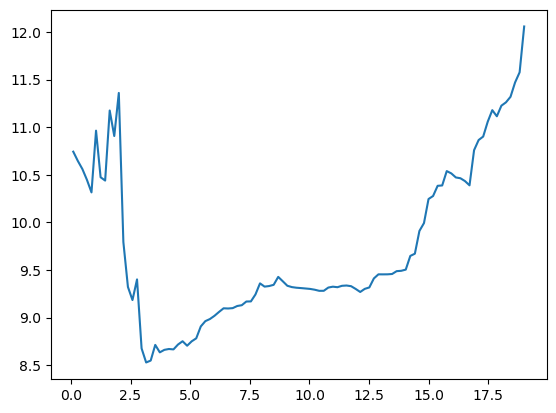

In [5]:
plt.plot(pardep['values'][0],pardep['average'][0])

This is an interesting plot. Based on the range of temperature values captured in our data, we see there are clearly two regimes of increased levels of predicted PM2.5 Because we have trained our model to years of data and used a robust tes-train-validate strategy, we can assume this is represetative of the real data. At low temperatures, there is a sharp increase. Likewise, as temperatures increase, we see levels increasing. These could be related to different emission and atmospheric transformation processes.

As already noted, partial dependency plots do have a number of limitations. It would be good to visualise the distribution of X values used. In the following function we modify an existing solution provided [online]() to generate the same information given above but also show the distribution of X values, thus temperature in this instance. 

Once defined we call this function in the proceeding code block.

In [6]:
def plot_pdp(model, X, feature, target=False, return_pd=False, y_pct=True, figsize=(10,9), norm_hist=True, dec=.5):
    # Get partial dependence
    pardep = partial_dependence(model, X, [feature])

    # Get min & max values
    xmin = pardep['values'][0].min() #pardep[1][0].min()
    xmax = pardep['values'][0].max() #pardep[1][0].max()
    ymin = pardep['average'][0].min() #pardep[0][0].min()
    ymax = pardep['average'][0].max()

    # Create figure
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.grid(alpha=.5, linewidth=1)

    # Plot partial dependence
    color = 'tab:blue'
    ax1.plot(pardep['values'][0],pardep['average'][0], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlabel(feature, fontsize=14)

    tar_ylabel = ': {}'.format(target) if target else ''
    ax1.set_ylabel('Partial Dependence{}'.format(tar_ylabel), color=color, fontsize=14)

    tar_title = target if target else 'Target Variable'
    ax1.set_title('Relationship Between {} and {}'.format(feature, tar_title), fontsize=16)

    if y_pct and ymin>=0 and ymax<=1:
        # Display yticks on ax1 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax1.get_yticklabels()]
        labels = [int(np.float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax1.set_yticklabels(labels)

    # Plot line for decision boundary
    ax1.hlines(dec, xmin=xmin, xmax=xmax, color='black', linewidth=2, linestyle='--', label='Decision Boundary')
    ax1.legend()

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.hist(X[feature], bins=80, range=(xmin, xmax), alpha=.25, color=color, density=norm_hist)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Distribution', color=color, fontsize=14)

    if y_pct and norm_hist:
        # Display yticks on ax2 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        labels = [int(np.float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax2.set_yticklabels(labels)

    plt.show()


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
FixedFormatter should only be used together with FixedLocator


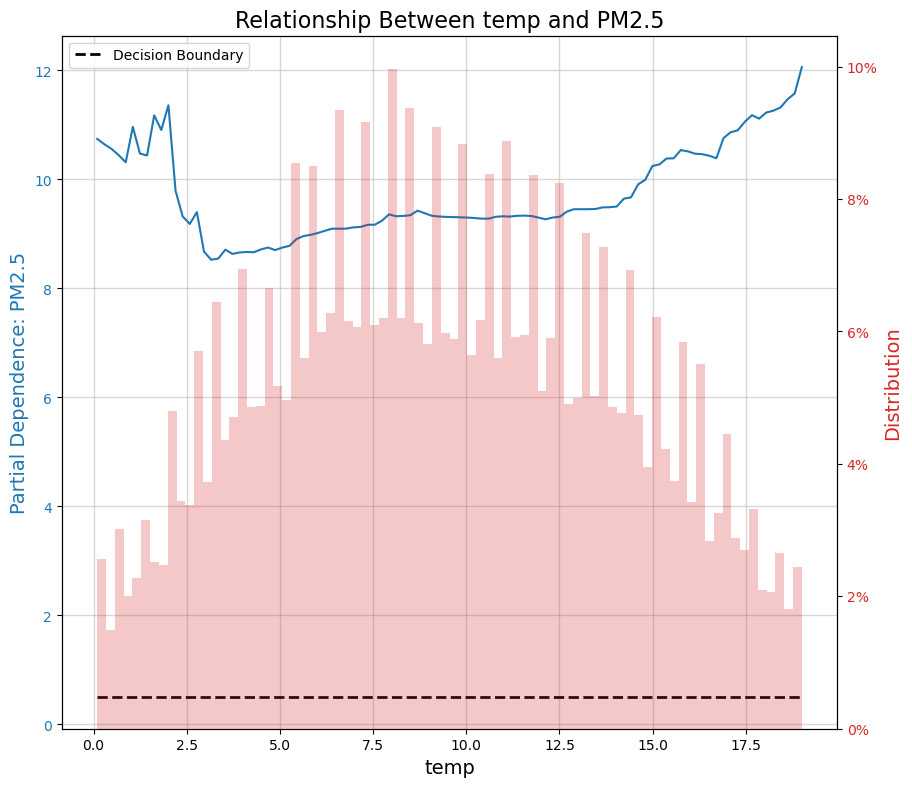

In [7]:
plot_pdp(best_xgb_model_new, forest_training[training_features_new], 'temp', target='PM2.5')

<div class="alert alert-block alert-success">
<b> Exercise 1 </b> 

##### Generate partial dependency plots to understand relationships between PM2.5 predictions and meteorology.
    
Repeat the above function call but for seperate instances of the following meteorological variables:
    
    - Relative humidity
    - Wind speed
    - Boundary layer height
    
You will need to identify the relevant column name from the dataframe for each one. For example, you should derive the following figure when generating a partial deendency of predicted PM2.5 on boundary layer height:
    
<img src="images/pdep_blh.png" alt="PDP with respect to boundary layer height" style="width: 600px;"/>
    

</div>

WARNING - (py.warnings._showwarnmsg) - `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

WARNING - (py.warnings._showwarnmsg) - FixedFormatter should only be used together with FixedLocator



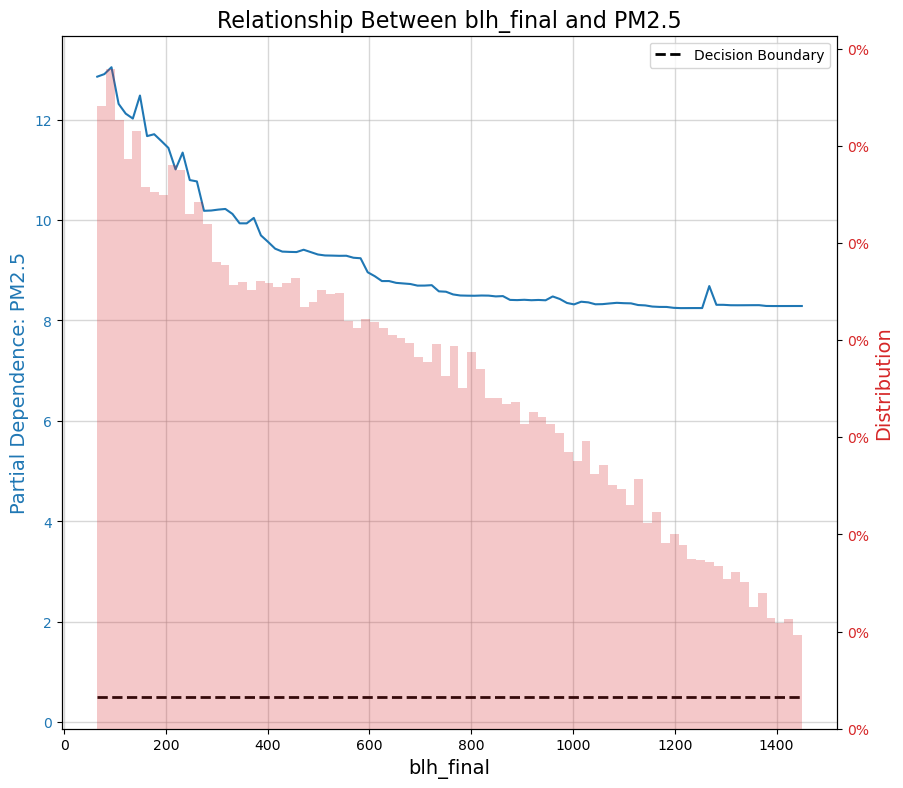

In [8]:
#------INSERT CODE HERE --------
plot_pdp(best_xgb_model_new, forest_training[training_features_new], 'blh_final', target='PM2.5')
#-------------------------------

### 2.2 SHAP analysis

In the above tet we refer to potentially more powerful analytics, including SHAP analysis. We retain the need to answer the question: Can we use the features and parameters of a trained model to understand the underlying relationships? Take the example of linear regression; Whilst the values of the learned coefficients might offer some insight these are not a great method for understanding the importance of a given feature. The scaling of the 'X' variable, for example, will impact on the value of the coefficient. The partial depedency plots above give more insight, but also we note that the distribution of values would affect confidence in areas where data is lacking.

SHAP (SHapley Additive exPlanations) analysis is a method used to explain the output of machine learning models, particularly for complex models such as deep learning and ensemble algorithms. The main goal of SHAP analysis is to provide an understandable and interpretable representation of how the features of an input instance contribute to the model's prediction.

SHAP analysis is based on the concept of Shapley values, which originated from cooperative game theory. Shapley values provide a way to fairly distribute a total value among multiple contributors, based on their individual contributions. Shapley values are a concept originating from cooperative game theory, proposed by Lloyd Shapley in 1953. They provide a method for fairly allocating the gains or costs of a cooperative game among its players, taking into account their individual contributions. The Shapley value has several desirable properties, such as efficiency, symmetry, dummy player property, and additivity.

In the context of machine learning, Shapley values are used to allocate the contribution of each feature to the model's prediction for a specific instance. The main idea is to treat the features as players in a cooperative game, where the "gain" is the difference between the prediction for the instance and the average prediction for the entire dataset.

Here's a more detailed explanation of the Shapley value calculation for a machine learning model:

 - 1. Consider all possible subsets of features, including the empty set and the set with all features. For a model with n features, there are 2^n possible subsets.
 - 2. For each subset, evaluate the model's prediction using only the features in that subset. For features not in the subset, use a reference value, such as the feature's mean or median value from the dataset.
  - 3. Calculate the marginal contribution of each feature by comparing the prediction of a subset that includes the feature with the prediction of the same subset without the feature.
  - 4. Compute the Shapley value for each feature by taking the weighted average of its marginal contributions across all possible subsets. The weight for each subset is given by the formula:
  - Weight = (|S|!(n-|S|-1)!)/(n!)

where |S| is the number of features in subset S, and n is the total number of features.
The Shapley values have some key properties that make them suitable for explaining machine learning models:

 - a) Efficiency: The sum of the Shapley values for all features equals the total gain, which is the difference between the model's prediction for the instance and the average prediction for the entire dataset.
 - b) Symmetry: If two features contribute equally to the model's prediction, they will have the same Shapley value.
 - c) Dummy player property: If a feature has no impact on the prediction, its Shapley value will be zero.
 - d) Additivity: If the gains from two different cooperative games can be combined, the Shapley values of the combined game will be the sum of the Shapley values of the individual games.

By using Shapley values, we can fairly allocate the contributions of each feature to the model's prediction and provide an interpretable explanation for complex machine learning models.

*One of the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.* 


We dont have to implement our own method to calculate Shapley values. We import the <code> shap </code> package to do this for us. We pass our previously fit model to a <code> TreeExplainer </code> function and extract shap values based on a validation dataset as per the code given below.

Notice that we have to create a training and validation split in our dataset again. We pass the validation datset to our SHAP analysis to extract the shapely values


In [7]:
# create train/validation split
Xt, Xv, yt, yv = train_test_split(forest_training[training_features_new],forest_training['PM2.5'], test_size=0.2, random_state=10)

explainer = shap.TreeExplainer(best_xgb_model_new)
shap_values = explainer.shap_values(Xv)


We can also use the internal depedency plot of the SHAP package to visualise the dependency on our regressed variable [in this case PM2.5], on any features. In the plot below, we can visualise the joint dependency on temperature and RH. Notice how, in this function call, we pass the value of <code> interaction_index </code>. In this case we set this to 'RH', the name of the column that represents relative humidity.

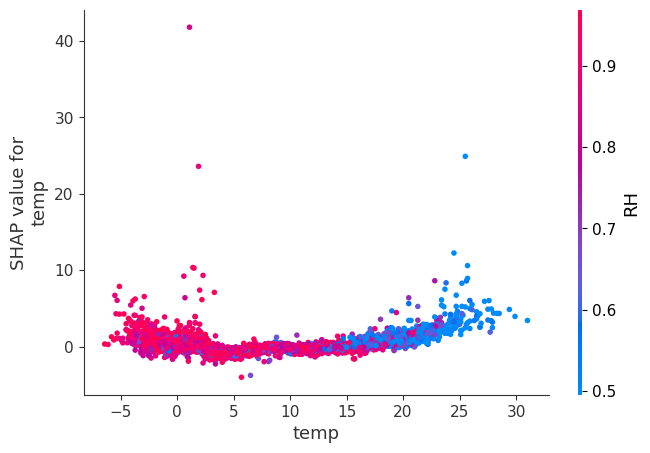

In [8]:
shap.dependence_plot("temp", shap_values, Xv, interaction_index="RH")


So we can see here that we still infer that predicted PM2.5 increases at lowest and highest temperatures. But we also see that those higher temperatures correspond to lower relative humidity, whilst the lower temperatures higher humidity. Does this make sense?

As another example, in the following code snippet we visualise the dependency between temperature and month of the year.

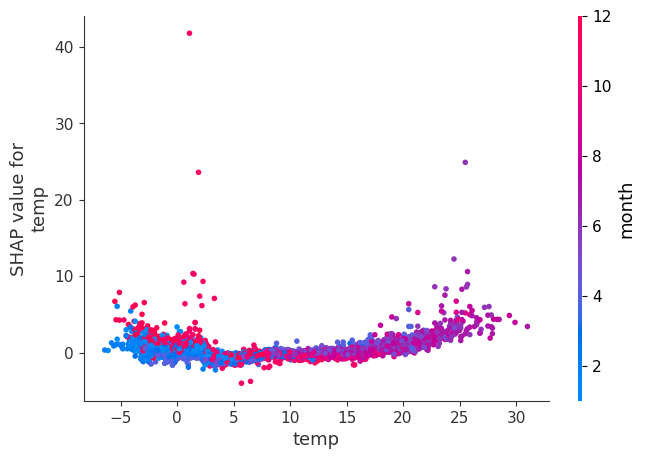

In [10]:
shap.dependence_plot("temp", shap_values, Xv, interaction_index="month")


<div class="alert alert-block alert-success">
<b> Exercise 2 </b> 

##### Generate SHAP analysis for Manchester Piccadilly site.
    
Repeat the above function call but for seperate instances of the following meteorological variables and interactions:
    
    - Relative humidity and day of the year
    - Wind speed and Boundary layer height
    
You will need to identify the relevant column name from the dataframe for each one.
    
</div>

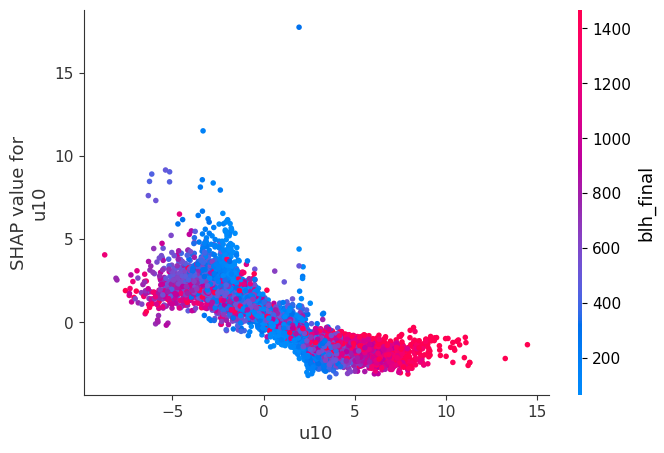

In [10]:
#------INSERT CODE HERE --------
shap.dependence_plot("u10", shap_values, Xv, interaction_index="blh_final")
#-------------------------------

What if we wanted to compare all variables alongside each other? For this we can use a summary plot. In the summary plot produced below, we can visualise the impact of each feature on the SHAP value as a function of the feature value. Please note that we cannot directly translate the SHAP value to the level of change in PM2.5. This calculation can also take a while to run. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


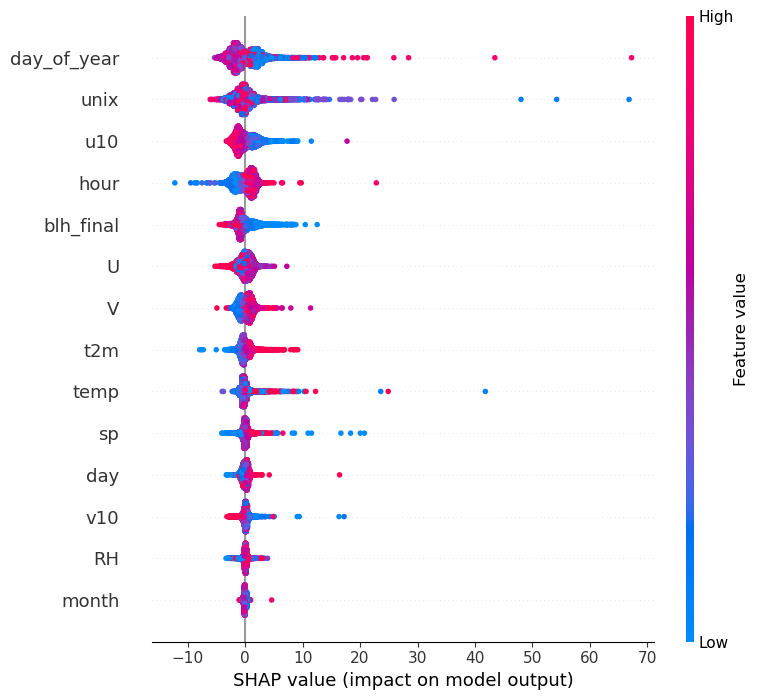

In [11]:
shap.summary_plot(shap_values, Xv)


<div class="alert alert-block alert-success">
<b> Exercise 3 </b> 

##### Load a pre-trained model used to predict NO2 and generate a summary SHAP analysis for Manchester Piccadilly site.
  
In this exercise we need to load another XGBoost model with the file name:
    
<code> NO2_predictor_picc.json </code>    
    
You can use the same dataset used in the previous summary plot; but you will need to make sure you specify the need to predict NO2, generate shapley values and then produce the summary plot. This should resemble the folllowing figure.
    
 <img src="images/shap_no2.png" alt="SHAP summary figure for predicted NO2" style="width: 600px;"/>


    
</div>

#### Exercise 3a) Load pre-trained model

In [12]:
# This line creates an instance of the XGBoost regressor
best_xgb_model_new_no2 = xgboost.XGBRegressor() 
# This line loads the pre-trained model 
#---------- INSERT CODE HERE ------------
best_xgb_model_new_no2.load_model( )     
#----------------------------------------

# set the feature names manually by using a list of names.
training_features_new = ['temp','U','V','t2m','u10','v10','blh_final','RH','sp','hour','day','month','unix','day_of_year']

# Set the names of the model using internal functions
best_xgb_model_new_no2.feature_names = training_features_new


[13:38:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035096581/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


#### Exercise 3a) Specify train and valiation dataset

In [13]:
#---------- INSERT CODE HERE ------------
Xt, Xv, yt, yv = train_test_split(forest_training[training_features_new],forest_training['NO2'], test_size=0.2, random_state=10)
#----------------------------------------

explainer = shap.TreeExplainer(best_xgb_model_new_no2)
shap_values = explainer.shap_values(Xv)

#### Exercise 3c) produce SHAP summary plot

WARNING - (py.warnings._showwarnmsg) - No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



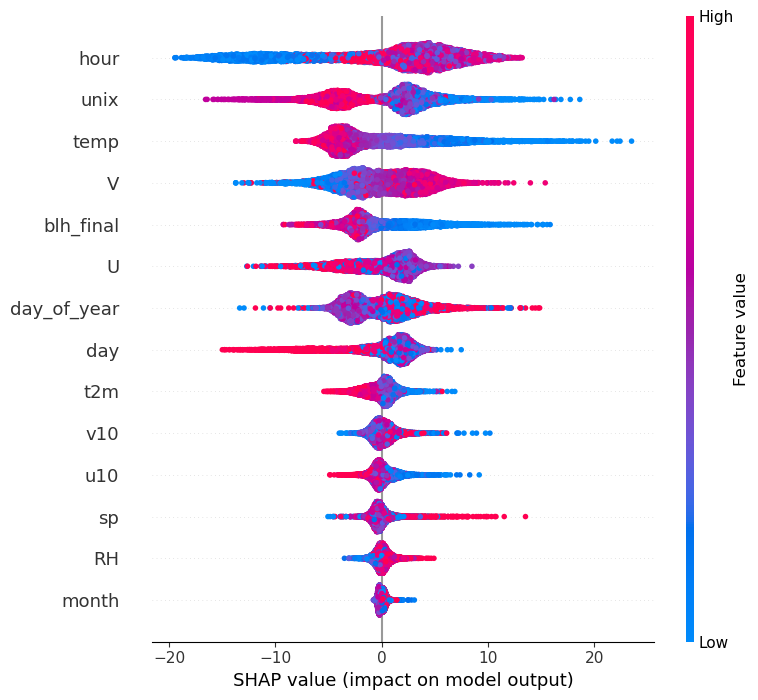

In [14]:
shap.summary_plot(shap_values, Xv)

## 2) Changepoint analysis 



<img src="images/changepoint.png" alt="General change-point analysis workflow [Selective review of offline change point detection methods
C Truong, L Oudre, N Vayatis - Signal Processing, 2020 - Elsevier]" style="width: 800px;"/>



Here we use a couple of approaches to try and extract points of change from a time-series. To detect impacts of air quality interventions, the ultimate aim would be to have a fully automated time series analysis that would identify points of change. This should include the ability to highlight local interventions and changes in regional patterns. Of course, this is challenging. There are a number of factors that can change concentrations of pollutants seperate to changes in local policy. These include:

 - Changes in meteorology
 - Instrument drift
 - Abnormal events such as woodland fires 
 
Changepoint analysis methods identify points of change within our time series dataset. We will need to confirm whether these points of change are the result of local interventions or supported by ancillary data including composition of PM, for example. 

In our class we are going to use two seperate packages to derive points of change and then you can use these methods within your project to build a narrative around the varying behaviour of pollution concentrations. The packages are listed below and described in more detail in subsequent sections:

 - The Ruptures Package: A collection of 
 - The Neural Prophet package


First lets load in the pre-processed weather noralise values for PM2.5 from Manchester Piccadilly and plot this alongside the raw values

In [11]:
dfnew=pd.read_csv(path+'/data/Reanalysis/weather_normalised_picc_test_PM.csv')
dfnew['datetime'] = pd.to_datetime(dfnew['Unnamed: 0'])
dfnew=dfnew.set_index('datetime')
dfnew.columns

Index(['Unnamed: 0', 'NO2', 'NO', 'PM2.5', 'Ox', 'NOx', 'temp', 'ws', 'wd',
       'U', 'V', 't2m', 'u10', 'v10', 'blh_final', 'sp', 'RH', 'hour', 'day',
       'month', 'unix', 'day_of_year', 'Day sin', 'Day cos', 'Year sin',
       'Year cos', 'PM_normalised'],
      dtype='object')

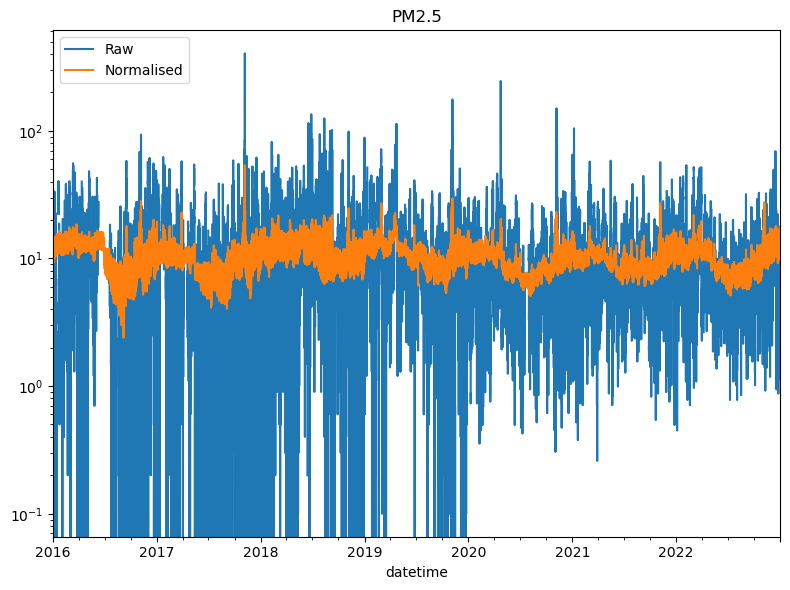

In [12]:
# Generate figure, axes and then populate with data on PM2.5 
fig, ax = plt.subplots(figsize=(8, 6))
dfnew['PM2.5'].plot(ax=ax, label="Raw")
dfnew['PM_normalised'].plot(ax=ax, label="Normalised")
ax.set_title('PM2.5')
ax.set_yscale('log')
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

We can also produce a joint histogram so we can better compare the distribution of values from the original and weather normalised values. In the code bo below we take the same function defined in an earlier notebook and compare the data for PM2.5. Notice how much tighter the distribution of values is for the normalised product. 

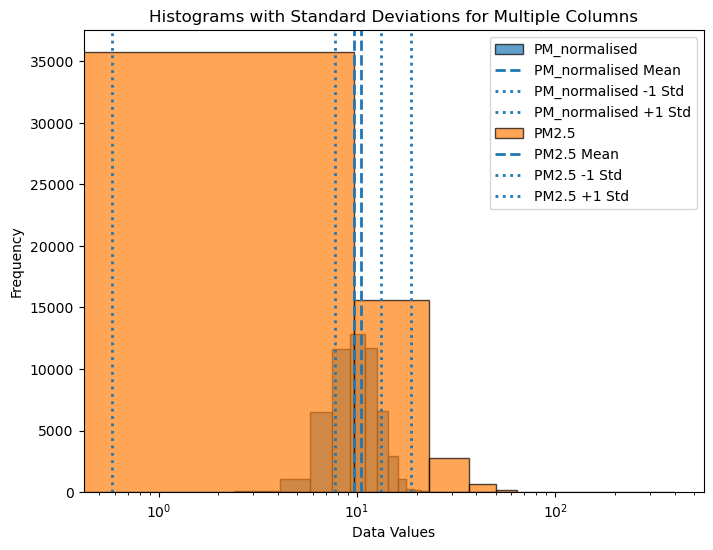

In [13]:
def plot_histograms_with_std(df, bins=10, alpha=0.7, std_lines=True, figsize=(8, 6)):
    """
    Plots histograms with vertical lines for the standard deviations for multiple columns in a Pandas DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        bins (int, optional): The number of bins to use for the histograms. Defaults to 10.
        alpha (float, optional): The transparency of the histogram bars. Defaults to 0.7.
        std_lines (bool, optional): Whether to plot the standard deviation lines. Defaults to True.
        figsize (tuple, optional): The size of the plot. Defaults to (12, 8).
    """

    # Set the plot size
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

    # Loop through the columns in the DataFrame
    for column in df.columns:
        # Calculate the mean and standard deviation for the current column
        mean = df[column].mean()
        std = df[column].std()

        # Plot the histogram for the current column
        plt.hist(df[column], bins=bins, alpha=alpha, edgecolor='black', label=column)

        # Plot the vertical lines for the standard deviations if required
        if std_lines:
            plt.axvline(mean, linestyle='dashed', linewidth=2, label=f'{column} Mean')
            plt.axvline(mean - std, linestyle='dotted', linewidth=2, label=f'{column} -1 Std')
            plt.axvline(mean + std, linestyle='dotted', linewidth=2, label=f'{column} +1 Std')

    # Set the labels and show the plot
    plt.xlabel('Data Values')
    plt.ylabel('Frequency')
    ax.set_xscale('log')
    plt.title('Histograms with Standard Deviations for Multiple Columns')
    plt.legend()
    plt.show()

# Example usage:
data = dfnew[['PM_normalised','PM2.5']].dropna()

plot_histograms_with_std(data,bins=30)


## 3.1) The CUMSUM algorithm

The CUMSUM (cumulative sum) algorithm is a change-point detection method used to identify shifts in the mean or other properties of a time series or sequential data. The main idea behind the CUMSUM algorithm is to calculate the cumulative sum of deviations from a reference value (usually a mean or a pre-specified value) and detect when these deviations indicate a significant change in the underlying process. The CUMSUM algorithm is widely used in quality control, fault detection, and anomaly detection in various fields, such as manufacturing, finance, and environmental monitoring.

Here is a simple outline of the CUMSUM algorithm for detecting changes in the mean of a univariate time series:

 - 1. Calculate the reference value: Determine a reference value that represents the expected mean (or other property) of the time series. This value can be based on historical data, expert knowledge, or a pre-specified threshold.
 - 2. Initialize the CUMSUM statistic: Set the initial CUMSUM statistic to zero (S[0] = 0).
 - 3. Calculate deviations from the reference value: For each observation in the time series (x_t), calculate the deviation from the reference value (x_t - reference_value).
 - 4. Update the CUMSUM statistic: For each observation, update the CUMSUM statistic as follows:
 > S[t] = S[t-1] + (x_t - reference_value), where S[t] is the CUMSUM statistic at time t.
 - 5. Calculate the decision statistic: At each time point t, calculate the decision statistic, which is the absolute value of the CUMSUM statistic (D[t] = |S[t]|).
 - 6. Set a decision threshold: Specify a decision threshold (h) based on the desired sensitivity and specificity for detecting changes. This threshold can be determined using simulation, historical data, or expert knowledge.
 - 7. Detect change points: If the decision statistic at a time point t exceeds the decision threshold (D[t] > h), it indicates a change point in the underlying process.
 - 8. Reset the CUMSUM statistic: Once a change point is detected, reset the CUMSUM statistic to zero (S[t] = 0) and continue monitoring for subsequent changes.

It's important to note that this is a basic version of the CUMSUM algorithm for detecting changes in the mean. There are more advanced variations of the algorithm that can handle multivariate data, detect changes in other properties (e.g., variance, distribution), and incorporate various adaptations for improved performance. The function below was generated using ChatGPT4.


In [14]:
def cumsum_algorithm(data, threshold_mean, threshold_std):
    mean_reference_value = np.mean(data)
    std_reference_value = np.std(data)

    S_mean = [0]
    S_std = [0]
    change_points = []

    for t in range(1, len(data)):
        S_mean.append(S_mean[t - 1] + (data[t] - mean_reference_value))
        S_std.append(S_std[t - 1] + ((abs(data[t] - mean_reference_value) - std_reference_value)))
        #pdb.set_trace()
        
        D_mean = abs(S_mean[t])
        D_std = abs(S_std[t])

        if D_mean > threshold_mean: #or D_std > threshold_std:
            #pdb.set_trace()
            change_points.append(t)
            S_mean[t] = 0
            S_std[t] = 0

    return change_points

Now that we have a function defined, we can pass our dataframe and pre-defined threshold values. Please notice this is ill defined in the sense that I have iterated on a set standard deviation and threshold mean to arrive at a 'small' number of changepoints. The actual changepoints provided back are dataframe index values that we need to convert into dates and times. We do that in the code block that foollows and then print those to the screen.

In [15]:
# define the data to be passed to the CUMSUM algorithm
data = dfnew['PM_normalised'].dropna().values

# Set reference value and threshold
threshold_std = 10
threshold_mean = 3000

# Apply CUMSUM algorithm
detected_change_points = cumsum_algorithm(data, threshold_mean, threshold_std)

In the code block below we convert row indices into actual dates. The reason we do this is so we can plot vertical lines at those dates on a time series plot to see if the changepoints somehow make sense.

In [16]:
change_points_cumsum = []
for entry in detected_change_points:
    change_points_cumsum.append(dfnew.iloc[entry-1]['Unnamed: 0'])
change_points_cumsum

['2016-02-18 09:00:00',
 '2016-03-24 05:00:00',
 '2016-05-17 23:00:00',
 '2016-09-19 20:00:00',
 '2017-07-09 05:00:00',
 '2017-08-18 03:00:00',
 '2018-04-11 20:00:00',
 '2018-06-16 09:00:00',
 '2019-02-01 21:00:00',
 '2019-03-03 10:00:00',
 '2019-04-16 10:00:00',
 '2020-02-17 15:00:00',
 '2020-07-14 02:00:00',
 '2020-08-16 17:00:00',
 '2020-10-03 13:00:00',
 '2021-07-09 11:00:00',
 '2021-09-19 20:00:00',
 '2022-03-29 04:00:00',
 '2022-07-07 06:00:00',
 '2022-08-15 07:00:00',
 '2022-10-04 09:00:00']

In the next code block we plot the normalised PM2.5 values. We then iterate through every changepoint extracted from the CUMSUM algorithm and plot a vertical line on the screen.

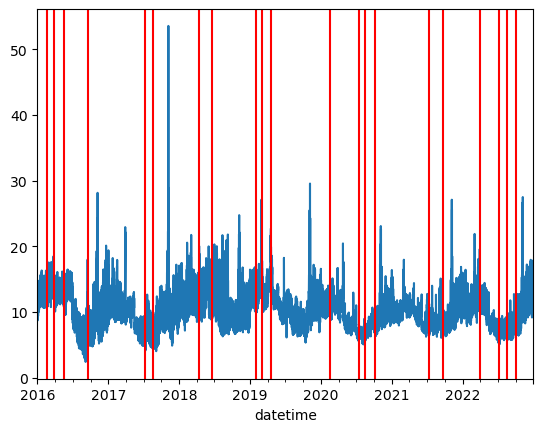

In [17]:
dfnew['PM_normalised'].plot()
for entry in change_points_cumsum:
    plt.axvline(pd.to_datetime(entry),color='r')
plt.show()

We cant take this graph as an end point. We need to interrogate the extracted points of change. They look cyclical, occuring after certain periods of time. Whilst it acts as an initial demonstrator, we should move on.

### 3.1 The Ruptures package 

The Ruptures package is a collection of tools for deriving changepoints, with varying computational speeds. We are going to use one of the quickest methods provided as detailed below.

#### 3.1.1 Sliding window analysis

In the sliding window approach, two sliding connected windows move through the signal. The statistical properties of those windows are compared and used to develop a discrepancy metric. Once this discrepancy reaches a threshold, we infer that we have detected a significant change. In the schematic below, taken from the official documentation of the [Ruptures package](https://centre-borelli.github.io/ruptures-docs/user-guide/detection/window/), we can see this in action. Of course, the usefulness of any outcome is sensitive to choice of hyperparameter in our model. As with any model we fit, we have a number of choices. 

<img src="images/schema_fenetre.png" alt="Sliding window schematic" style="width: 800px;"/>


First we import the ruptures package.

In [18]:
import ruptures as rpt

In the following few lines of code we deploy the sliding window method. We retain the same variable names used in the official documentation. The 'signal' represents the univariate time series signal we wish to detect change in. There are a number of lines we will discuss n class, but you do not need to worry about their background. 

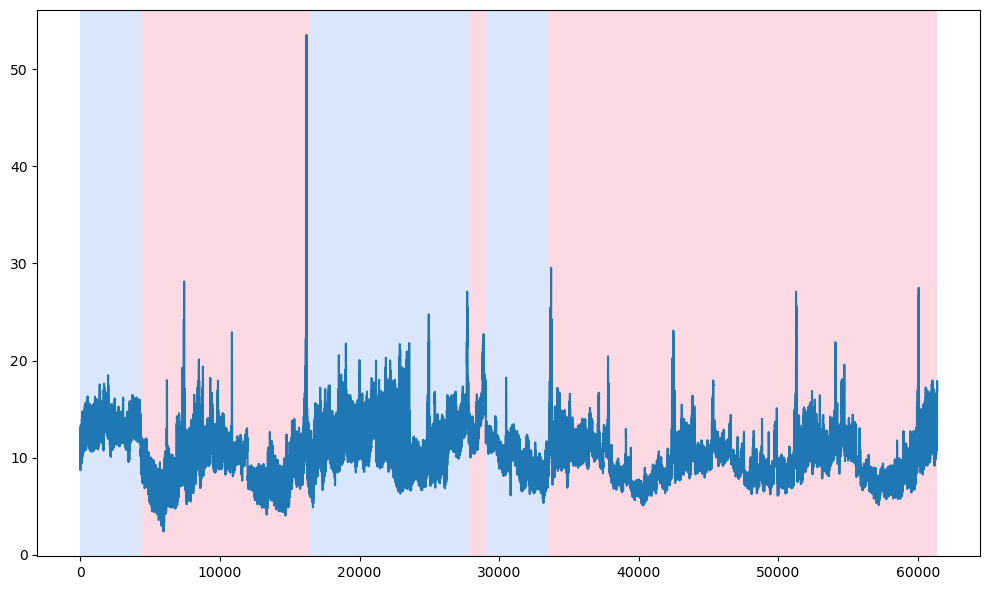

In [19]:
# Define the univariate time series signal we wish to detect change in
signal = dfnew['PM_normalised'].values
# Define a model used in the changepoint detection calculation. 
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
# Call the sliding window method, specifying the width of the window used [720 hours ~ 1 month]
algo = rpt.Window(width=720, model=model).fit(signal)
# In this instance, we ask the method to predict a set number of changepoints [n_bkps]
my_bkps = algo.predict(n_bkps=5)
# show results
rpt.show.display(signal,my_bkps, figsize=(10, 6))
plt.show()

In the graph produced, we see the time series of normalised values versus a, rather unhelpful, index number of our dataframe. At every location where the background colour changes, is the extracted changepoint. We see 5 changes, as requested from the method.

In many cases we do not want to specify our own number of changepoints. Some methods provide strategies to extract the number of points in an automated way. To quote the developer of the Ruputures package, *This is one of the most difficult questions in change-point detection. When you do not know the number of changes beforehand, you must use a penalized approach* [original quote](https://github.com/deepcharles/ruptures/issues/257)


This still requires us to define how the automated method works and we still have to interpret the extracted points. According to the Ruptures documentation, within the sliding window method, we can define a penalty term that is used to detect changepoints:

 - $2\sigma^{2}log(T)(d+1)$
 
where $T$ i the number of observations, $d$ the number of dimensions and $\sigma$ the standard deviation. In the code block this is calculated for our signal. Where does this come from??

In the context of change point detection, The Bayesian Information Criterion (BIC) can be used as a penalty term to prevent overfitting. When trying to detect change points in a time series, it's possible to overfit the data by identifying too many change points. The BIC helps mitigate this by introducing a penalty term that increases with the number of change points. This penalty discourages excessive complexity in the model.

The following code allows us to calculate the penalty term specified in the Ruptures documentation. 

In [20]:
sigma = np.std(signal) # standard deviation of the signal
dim = 1 # number of dimensions - 1 as it is univariate
length = len(signal) # number of observations
penalty=2* np.log(length) * 2*dim * sigma**2 # the penalty term defined above

Now that we have a penalty defined, we can once again call the rolling window method but rather than specify a fixed number of changepoints we can specify a penalty term and fit the model accordingly. This is demonstrated in the box below and 

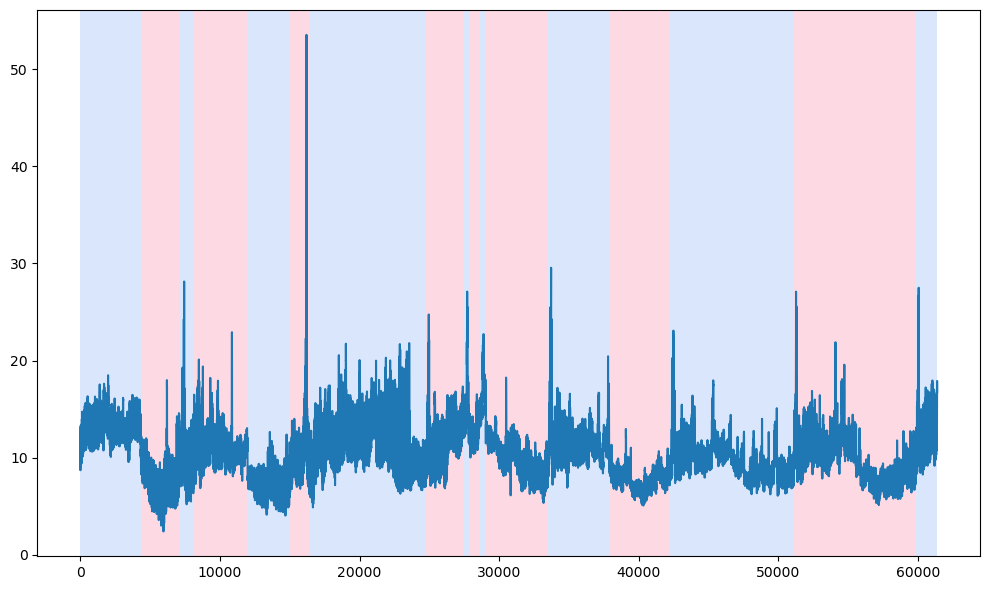

In [21]:
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=720, model=model).fit(signal)
my_bkps = algo.predict(pen=penalty)
# show results
rpt.show.display(signal,my_bkps, figsize=(10, 6))
plt.show()

We can visualise the inferred points of change from the above graph, but we have lost an idea of time along our x axis. If we inspect the variable 'my_bkps' below we wil find this is simply a list of index values:

In [22]:
my_bkps

[4325,
 7060,
 8140,
 11980,
 15040,
 16350,
 24725,
 27390,
 27875,
 28580,
 29040,
 33500,
 37870,
 42230,
 51120,
 59855,
 61368]

We can use those index values to pull out the actual times from our original dataframe. The following code block uses the .iloc indexing property of a dataframe to do that and then print to the screen.

In [23]:
change_points = []
for entry in my_bkps:
    change_points.append(dfnew.iloc[entry-1]['Unnamed: 0'])
change_points

['2016-06-29 04:00:00',
 '2016-10-21 03:00:00',
 '2016-12-05 03:00:00',
 '2017-05-14 03:00:00',
 '2017-09-18 15:00:00',
 '2017-11-12 05:00:00',
 '2018-10-27 04:00:00',
 '2019-02-15 05:00:00',
 '2019-03-07 10:00:00',
 '2019-04-05 19:00:00',
 '2019-04-24 23:00:00',
 '2019-10-27 19:00:00',
 '2020-04-26 21:00:00',
 '2020-10-25 13:00:00',
 '2021-10-30 23:00:00',
 '2022-10-29 22:00:00',
 '2022-12-31 23:00:00']

We can also use these dates to highlight specific rows in a pandas dataframe plot.

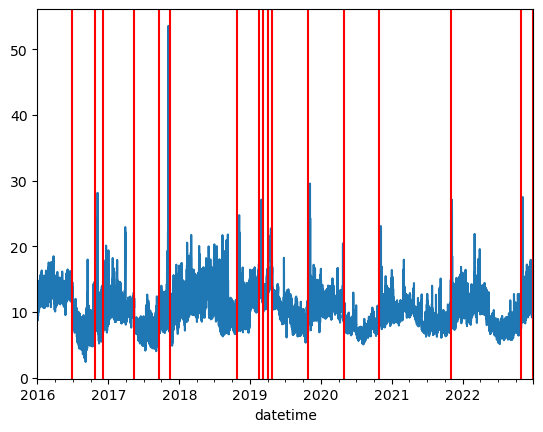

In [24]:
dfnew['PM_normalised'].plot()
for entry in change_points:
    plt.axvline(pd.to_datetime(entry),color='r')
plt.show()

This is now interesting. It seems the method is picking out events of high loading, even in the normalised values. 
 

<div class="alert alert-block alert-success">
<b> Exercise 4 </b> 

##### Assess sensitivity of derived changepoints from sliding window analysis.
    
In the code block below, change the sliding window period and observe where in the time series the changepoints emerge using the code given above. The resolution of opur data is given in hours so 720 datapoints represents 30 days. What happens to the number of extracted changepoints when you use a window of 3 months [2190 observations?]. Calculate the number of changepoints and plot alongside the previous calculated points on the same graph. Most of the code is already provided for you. Please fill in the blanks where required. 

</div>

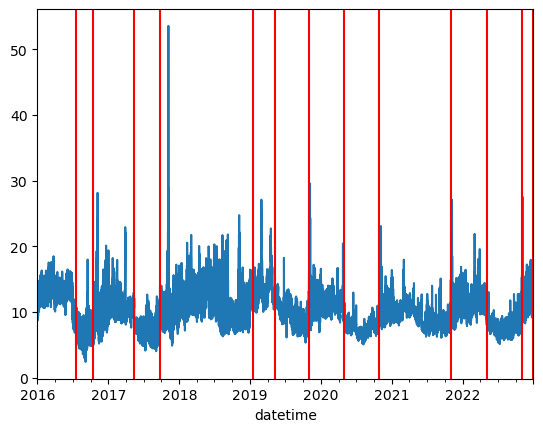

In [25]:
sigma = np.std(signal) # standard deviation of the signal
dim = 1 # number of dimensions - 1 as it is univariate
length = len(signal) # number of observations
penalty=2* np.log(length) * 2*dim * sigma**2 # the penalty term defined above

# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
#-------------- INSERT CODE HERE ---------------------
algo = rpt.Window(width= , model=model).fit(signal)
my_bkps = algo.predict(pen=penalty)
#-----------------------------------------------------

change_points = []
for entry in my_bkps:
    change_points.append(dfnew.iloc[entry-1]['Unnamed: 0'])
change_points

dfnew['PM_normalised'].plot()
for entry in change_points:
    plt.axvline(pd.to_datetime(entry),color='r')
plt.show()

We can even compare changepoints for both the raw and 'normalised' PM2.5 values . Using a window of 720 observations, in the following code block we compare the extracted changepoints using both the 'raw' and weather normalised signal. Please remember that our penalty term is derived from the time-series data of interest, so you we need to calculate the appropriate terms.     

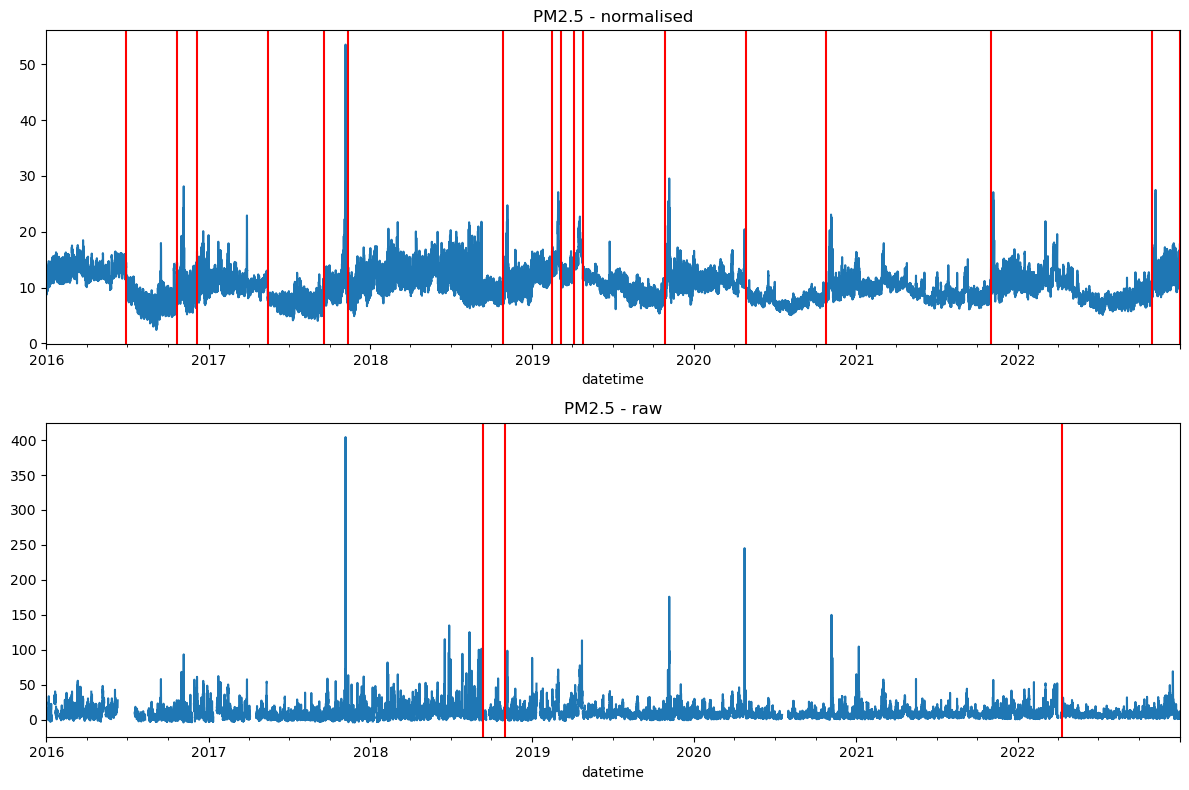

In [26]:
# -------------Generate changepoints from normalised data--------------
sigma_normalised = np.std(signal) # standard deviation of the signal
dim_normalised = 1 # number of dimensions - 1 as it is univariate
length_normalised = len(signal) # number of observations
penalty_normalised=2* np.log(length_normalised) * 2*dim_normalised * sigma**2 # the penalty term defined above

# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=720, model=model).fit(signal)
my_bkps_normalised = algo.predict(pen=penalty_normalised)

change_points_normalised = []
for entry in my_bkps_normalised:
    change_points_normalised.append(dfnew.iloc[entry-1]['Unnamed: 0'])

# -------------Generate changepoints from raw data--------------
signal_raw = dfnew.dropna()['PM2.5'].values
sigma_raw = np.std(signal_raw) # standard deviation of the signal
dim_raw = 1 # number of dimensions - 1 as it is univariate
length_raw = len(signal_raw) # number of observations
penalty_raw=2* np.log(length_raw) * 2*dim_raw * sigma_raw**2 # the penalty term defined above

# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=720, model=model).fit(signal_raw)
my_bkps_raw = algo.predict(pen=penalty_raw)

change_points_raw = []
for entry in my_bkps_raw:
    change_points_raw.append(dfnew.iloc[entry-1]['Unnamed: 0'])

# ---- Plot the results ------
fig, axes = plt.subplots(2,1,figsize=(12,8))    
dfnew['PM_normalised'].plot(ax=axes[0])
for entry in change_points_normalised:
    axes[0].axvline(pd.to_datetime(entry),color='r')
dfnew['PM2.5'].plot(ax=axes[1])
for entry in change_points_raw:
    axes[1].axvline(pd.to_datetime(entry),color='r')    
axes[0].set_title('PM2.5 - normalised')
axes[1].set_title('PM2.5 - raw')
fig.tight_layout()    
plt.show()

Notice how we seem to have lost sensitivity, if we can define it this way, when using the raw data.